# Coding Assignment 1 - Jack Kovach and Matthew Lopes

## Data Generation

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knn

# Set seed
np.random.seed(100)

In [47]:
p = 2
csize = 10
sigma = 1
m1 = np.random.normal(size = (csize, p)) * sigma + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * sigma + np.concatenate([np.array([[0, 1]] * csize)])

class sim_params :
    csize = 10           # number of centers
    p = 2                # dimension
    s = np.sqrt(1 / 5)   # standard deviation for generating data
    n = 100              # training size per class
    N = 5000             # test size per class
    m0 = m0              # 10 centers for class 0
    m1 = m1              # 10 centers for class 1

In [48]:
def generate_sim_data(sim_params):

    p = sim_params.p
    s = sim_params.s
    n = sim_params.n
    N = sim_params.N
    m1 = sim_params.m1
    m0 = sim_params.m0
    csize = sim_params.csize
    
    id1 = np.random.randint(csize, size = n)
    id0 = np.random.randint(csize, size = n)

    Xtrain = np.random.normal(size = (2 * n, p)) * s \
                + np.concatenate([m1[id1,:], m0[id0,:]])
    Ytrain = np.concatenate(([1]*n, [0]*n))

    id1 = np.random.randint(csize, size = N)
    id0 = np.random.randint(csize, size = N)
    Xtest = np.random.normal(size = (2 * N, p)) * s \
                + np.concatenate([m1[id1,:], m0[id0,:]])
    Ytest = np.concatenate(([1]*N, [0]*N))

    return Xtrain, Ytrain, Xtest, Ytest

In [49]:
Xtrain, Ytrain, Xtest, Ytest = generate_sim_data(sim_params)

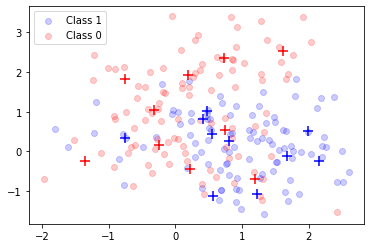

In [50]:
n = sim_params.n
m0 = sim_params.m0        
m1 = sim_params.m1

plt.figure()
plt.scatter(Xtrain[:n, 0], Xtrain[:n, 1], 
            color = 'blue', alpha = 0.2, label = 'Class 1')
plt.scatter(Xtrain[n:, 0], Xtrain[n:, 1], 
            color = 'red', alpha = 0.2, label = 'Class 0')
plt.scatter(m1[:, 0], m1[:, 1], marker = '+', color = 'blue', s = 120)
plt.scatter(m0[:, 0], m0[:, 1], marker = '+', color = 'red', s = 120)
plt.legend()
plt.show()

## Part 1: KNN

Our KNN Implementation

Reference: https://towardsdatascience.com/k-nearest-neighbors-classification-from-scratch-with-numpy-cb222ecfeac1

In [51]:
def euclidian_distance(a, b):
    return np.sqrt(np.sum((a-b)**2, axis=1))

In [52]:
def kneighbors(X_test):
       
        n_neighbors = 1
        dist = []
        neigh_ind = []
        
        point_dist = [euclidian_distance(x_test, Xtrain) for x_test in X_test]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:n_neighbors]
    
            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]
    
            dist.append(dist_list)
            neigh_ind.append(ind_list)
        
        return np.array(neigh_ind)

In [53]:
def predict(X_test):

        neighbors = kneighbors(X_test)
        Ypred = np.array([np.argmax(np.bincount(Ytrain[neighbor])) for neighbor in neighbors])

        return Ypred 

In [54]:
def confusion_matrix(Ytrue, Ypred):
    return np.bincount(Ytrue + 2*Ypred).reshape(2, 2)

In [55]:
Ypred = predict(Xtest)

print(pd.crosstab(Ypred, Ytest))
print()
print(np.mean(Ypred != Ytest))
print()
print(confusion_matrix(Ytest,Ypred))
print()
print((1635 + 1461) / (2* sim_params.N))

col_0     0     1
row_0            
0      3365  1461
1      1635  3539

0.3096

[[3365 1461]
 [1635 3539]]

0.3096


KNN from sklearn

In [56]:
## MOVED TO ABOVE FOR COMPARISON ##

# def confusion_matrix(Ytrue, Ypred):
#     return np.bincount(Ytrue + 2*Ypred).reshape(2, 2)

# print('K = 1: ')
knn_model = knn(n_neighbors = 1)
knn_model.fit(Xtrain, Ytrain)
test_pred = knn_model.predict(Xtest)

print(confusion_matrix(Ytest, test_pred)) # same as pd.crosstab
print()
print(pd.crosstab(test_pred, Ytest))
print()
print(np.mean(test_pred != Ytest))
print()
print((1635 + 1461) / (2* sim_params.N))

[[3365 1461]
 [1635 3539]]

col_0     0     1
row_0            
0      3365  1461
1      1635  3539

0.3096

0.3096


### Test Runs for K = 1, K = 3, K = 5

### Distance Ties and Voting Ties

## Part 2: cv-KNN

In the second part of this assignment, you are asked to

1: Implement KNN classification with K chosen by 10-fold cross-validation;

2: Explain how you handle the non-uniquness of the optimal K values.

Candidate K values are from 1 to 180.
For this part, you are allowed to use the function knn from R package class, instead of your own KNN function from Part I.

## Compute CV Errors

First, divide the training data equally into ten folds,
then compute the prediction error on each fold using the KNN classifier trained based on the other nine folds.

Specially, in the code below, we set K = 3 and loop over runId from 1 to 10 to compute the CV error. For example, when runId = 3, we find the indices of samples in the 3rd fold (stored in testSetIndex), then train a KNN model without data in testSetIndex, and finally form prediction on data in testSetIndex.

Sample code for computing CV error for a particular K value.

In [57]:
num_folds = 10
n = len(Ytrain)
fold_size = int(n / num_folds)  
K = 3 # K = 3 for Demo Code ONLY
err = 0

indices = np.arange(n)
np.random.shuffle(indices)
index_sets = np.array_split(indices, num_folds)

traindata = Xtrain

for ifold in range(num_folds):
    train_indices =  np.delete(index_sets, obj=ifold, axis=0).ravel()
    _traindata = traindata[train_indices]
    _Ytrain = Ytrain[train_indices]
    
    test_indices = index_sets[ifold]
    _testdata = traindata[test_indices]
    _Ytest = Ytrain[test_indices]
   
    knn_model = knn(K)
    knn_model.fit(_traindata, _Ytrain)
    predict_Y = knn_model.predict(_testdata)
    err += sum(predict_Y != _Ytest)
    
err /= float(n)
err

0.235

## get_cv_err function 

Built from the sample code

In [58]:
def get_cv_err(Ytrain, traindata, K):
    num_folds = 10
    n = len(Ytrain)
    fold_size = int(n / num_folds)  
    #K = 3
    err = 0

    indices = np.arange(n)
    np.random.shuffle(indices)
    index_sets = np.array_split(indices, num_folds)

    for ifold in range(num_folds):
        train_indices =  np.delete(index_sets, obj=ifold, axis=0).ravel()
        _traindata = traindata[train_indices]
        _Ytrain = Ytrain[train_indices]

        test_indices = index_sets[ifold]
        _testdata = traindata[test_indices]
        _Ytest = Ytrain[test_indices]

        knn_model = knn(K)
        knn_model.fit(_traindata, _Ytrain)
        predict_Y = knn_model.predict(_testdata)
        err += sum(predict_Y != _Ytest)

    err /= float(n)
    return err

In [59]:
def cvKNN(traindata, y_train, num_folds):
    n = len(Ytrain)
    fold_size = int(n / num_folds)
    kvector = range(1, n - fold_size)
    
    ########################################
    # Your Code
    # Compute CV errors and store them in k_cverr
    #########################################
    k_cverr = []
    for k in kvector:
        k_cverr.append(get_cv_err(y_train,traindata,k))
        
    k_cverr = np.asarray(k_cverr)
    
    tmp = np.column_stack((kvector, k_cverr))
    best_k = tmp[tmp[:,1] == np.min(tmp[:,1])][:,0]
    return int(np.max(best_k))

best_k = cvKNN(Xtrain, Ytrain, num_folds)
cvKNN = knn(n_neighbors=best_k)
cvKNN.fit(Xtrain, Ytrain)

y_pred_cvknn = cvKNN.predict(Xtest)
print(y_pred_cvknn)

[1 0 0 ... 0 1 0]


In [60]:
print(confusion_matrix(Ytest, y_pred_cvknn)) # same as pd.crosstab
print()
print(pd.crosstab(y_pred_cvknn, Ytest))
print()
print(np.mean(y_pred_cvknn != Ytest))
print()
print((1442 + 1075) / (2* sim_params.N))

[[3531 1014]
 [1469 3986]]

col_0     0     1
row_0            
0      3531  1014
1      1469  3986

0.2483

0.2517


### How we handle the non-uniquness of the optimal K values

From the assignment specification it is stated: it is possible that multiple K values give the (same) smallest CV error; when this happens, pick the largest K value among them, since the larger the K value, the simpler the model. This is what we implemented

## Part III: Bayes Rule
In the third part of this assignment, you are asked to Implement the Bayes Rule.

The Bayes rule for binary classification (under the zero-one loss), as derived in class, is: predict Y to be 1, if
$$ P(Y=1∣X=x)≥P(Y=0∣X=x), $$
or equivalently
$$\frac{P(Y=1∣X=x)}{P(Y=0∣X=x)}≥1. $$

Following the data generation process, we have

$$ \frac{P(Y=1∣X=x)}{P(Y=0∣X=x)}=\frac{P(Y=1)⋅P(X=x∣Y=1)}{P(Y=0)⋅P(X=x∣Y=0)}$$

$$=\frac{(1/2)⋅10^{−1}\sum\limits_{l=1}^{10}(2πs^2)^{−1}exp(−∥x−m_{1l}∥^2/(2s^2))}{(1/2)⋅10^{−1}\sum\limits_{l=1}^{10}(2πs^2)^{−1}exp(−∥x−m_{0l}∥^2/(2s^2))}$$

$$ =\frac{\sum\limits_{l=1}^{10}exp(−∥x−m_{1l}∥^2/(2s^2))}{\sum\limits_{l=1}^{10}exp(−∥x−m_{0l}∥^2/(2s^2))} $$
You can use the following code to compute the numerator and the denominator of this ratio.

In [61]:
s = sim_params.s
print(m1)
print()
print(m0)
print()
print(s)

[[-0.74976547  0.3426804 ]
 [ 2.1530358  -0.25243604]
 [ 1.98132079  0.51421884]
 [ 1.22117967 -1.07004333]
 [ 0.81050417  0.25500144]
 [ 0.54197301  0.43516349]
 [ 0.41640495  0.81684707]
 [ 1.67272081 -0.10441114]
 [ 0.46871962  1.02973269]
 [ 0.56186438 -1.11831825]]

[[ 1.61898166  2.54160517]
 [-0.25187914  0.15756426]
 [ 0.18451869  1.9370822 ]
 [ 0.73100034  2.36155613]
 [-0.32623806  1.05567601]
 [ 0.22239961 -0.443217  ]
 [-0.75635231  1.81645401]
 [ 0.75044476  0.54405307]
 [ 1.18962227 -0.69061683]
 [-1.35639905 -0.23243451]]

0.4472135954999579


In [62]:
ratios = []
for x in Xtest:
    d1 = sum(np.exp(- ((m1[i, 0] - x[0]) ** 2 + (m1[i, 1] - x[1]) ** 2) / (2 * s ** 2)) for i in range(len(m1)))
    d0 = sum(np.exp(- ((m0[i, 0] - x[0]) ** 2 + (m0[i, 1] - x[1]) ** 2) / (2 * s ** 2)) for i in range(len(m0)))
    ratios.append(d1/d0)
ratios = np.asarray(ratios)
print(ratios)
bayes_y_pred = (ratios >= 1).astype(int)
print(bayes_y_pred)

[4.38881427e+00 1.57220629e+00 1.38242758e-01 ... 3.31632443e-01
 1.73681655e+00 2.27337445e-03]
[1 1 0 ... 0 1 0]


In [63]:
print(pd.crosstab(bayes_y_pred, Ytest))
print()
print(np.mean(bayes_y_pred != Ytest))
print()

col_0     0     1
row_0            
0      3489   859
1      1511  4141

0.237



## Part IV: Simulation Study

In the last part of this assignment, you are asked to use the same set of centers m1 and m0, and repeatedly call generate_sim_data to generate 50 data sets. For each data set, calculate the test errors (the averaged 0/1 loss on the test data set) for each the following three procedures:

KNN classification with K = 1,
KNN classification with K chosen by 10-fold cross-validation, and
the Bayes Rule.
Present the test errors graphically, e.g., using boxplot or stripchart. Also report the mean and standard error for the chosen K values.

Note:

For KNN, you can use the function knn from R package class, instead of your own KNN function from Part II.

“report the mean and standard error for the chosen K values” – For each of the 50 data sets, you’ll have a K value chosen via 10-fold CV. Report the mean and standard error of those 50 values.



In [64]:
def cvKNN2(traindata, y_train, num_folds):
    n = len(Ytrain)
    fold_size = int(n / num_folds)
    kvector = range(1, n - fold_size)
    
    ########################################
    # Your Code
    # Compute CV errors and store them in k_cverr
    #########################################
    k_cverr = []
    for k in kvector:
        k_cverr.append(get_cv_err(y_train,traindata,k))
        
    k_cverr = np.asarray(k_cverr)
    
    tmp = np.column_stack((kvector, k_cverr))
    best_k = tmp[tmp[:,1] == np.min(tmp[:,1])][:,0]
    return int(np.max(best_k))

In [65]:
def sim_one_knn(Xtrain,Ytrain,Xtest,Ytest):
    knn_model = knn(n_neighbors = 1)
    knn_model.fit(Xtrain, Ytrain)
    test_pred = knn_model.predict(Xtest)
    
    return np.mean(test_pred != Ytest)

In [66]:
def sim_cv_knn(Xtrain, Ytrain, Xtest, Ytest, num_folds):
    best_k = cvKNN2(traindata=Xtrain, y_train=Ytrain, num_folds=num_folds)
    cvKNN = knn(n_neighbors=best_k)
    cvKNN.fit(Xtrain, Ytrain)
    y_pred_cvknn = cvKNN.predict(Xtest)
    
    return best_k, np.mean(y_pred_cvknn != Ytest)

In [67]:
def sim_bayes(Xtrain, Ytrain, Xtest, Ytest):
    ratios = []
    for x in Xtest:
        d1 = sum(np.exp(- ((m1[i, 0] - x[0]) ** 2 + (m1[i, 1] - x[1]) ** 2) / (2 * s ** 2)) for i in range(len(m1)))
        d0 = sum(np.exp(- ((m0[i, 0] - x[0]) ** 2 + (m0[i, 1] - x[1]) ** 2) / (2 * s ** 2)) for i in range(len(m0)))
        ratios.append(d1/d0)
    ratios = np.asarray(ratios)
    bayes_y_pred = (ratios >= 1).astype(int)
    
    return np.mean(bayes_y_pred != Ytest)

In [68]:
datasets = []
one_knn_errs = []
best_k_errs = []
best_k_cvKNN = []
bayes_errs =[]
for i in range(50):
    X_train, Y_train, X_test, Y_test = generate_sim_data(sim_params)
    one_knn_errs.append(sim_one_knn(X_train, Y_train, X_test, Y_test))
    
    best_k, best_k_err = sim_cv_knn(X_train, Y_train, X_test, Y_test,10)
    best_k_errs.append(best_k_err)
    best_k_cvKNN.append(best_k)
    
    bayes_errs.append(sim_bayes(X_train, Y_train, X_test, Y_test))
    datasets.append((Xtrain, Ytrain, Xtest, Ytest))

In [73]:
## Mean and Standard Deviation of K not the errors
mean_best_k_cvKNN = np.mean(best_k_cvKNN)
std_err_best_k_cvKNN = np.std(best_k_cvKNN, ddof=1) / np.sqrt(np.size(best_k_cvKNN))

print("mean_best_k_cvKNN")
print(mean_best_k_cvKNN)
print()
print("std_err_best_k_cvKNN")
print(std_err_best_k_cvKNN)

mean_best_k_cvKNN
33.12

std_err_best_k_cvKNN
2.852086955196142


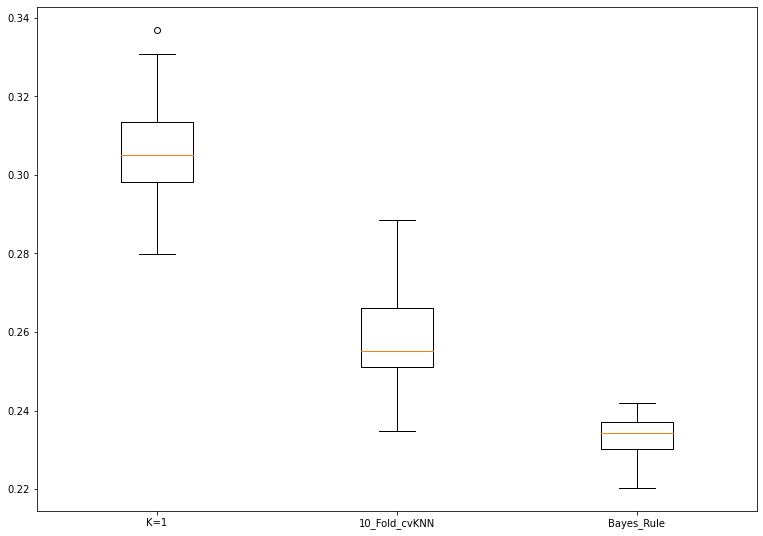

In [70]:
data = [one_knn_errs, best_k_errs, bayes_errs]
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data)
plt.xticks([1, 2, 3], ['K=1', '10_Fold_cvKNN', 'Bayes_Rule'])
# show plot
plt.show()

In [71]:
print(mean_best_k_cvKNN)
print(std_err_best_k_cvKNN)

33.12
2.852086955196142


In [74]:
print(best_k_errs)

[0.2535, 0.264, 0.2463, 0.251, 0.2596, 0.2672, 0.2645, 0.2553, 0.2745, 0.2684, 0.2399, 0.2671, 0.255, 0.2468, 0.2738, 0.2349, 0.2453, 0.2886, 0.239, 0.2509, 0.2528, 0.2557, 0.2495, 0.2546, 0.2533, 0.2453, 0.2511, 0.2787, 0.2554, 0.2668, 0.2538, 0.262, 0.2511, 0.2465, 0.2759, 0.2517, 0.258, 0.2542, 0.2467, 0.2506, 0.2695, 0.2534, 0.2774, 0.2597, 0.2761, 0.2643, 0.2524, 0.264, 0.2604, 0.2735]


In [75]:
print(best_k_cvKNN)

[50, 37, 9, 29, 37, 74, 17, 21, 67, 59, 30, 17, 51, 46, 87, 22, 16, 76, 26, 17, 9, 34, 27, 29, 9, 10, 23, 3, 13, 19, 31, 62, 52, 20, 7, 39, 39, 9, 40, 41, 5, 48, 36, 34, 36, 11, 38, 48, 32, 64]


In [76]:
print(np.std(best_k_cvKNN, ddof=1))

20.16730026552885
